In [17]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import * 
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt

In [4]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 8
macro_configs = config_generator(learn_alg=['BPTT', 'DNI', 'RFLO'])
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

In [5]:
root_name = 'Fig_3_4_Algorithm_Variations_Result'
file_names = []
for params, i_seed in micro_configs:
    
    np.random.seed(i_seed)

    task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
    N_train = 50000
    N_test = 2000
    checkpoint_interval = 100

    data = task.gen_data(N_train, N_test)

    n_in = task.n_in
    n_hidden = 32
    n_out = task.n_out
    W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
    W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
    W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

    b_rec = np.zeros(n_hidden)
    b_out = np.zeros(n_out)

    alpha = 1
    sigma = 0

    rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
              activation=tanh,
              alpha=alpha,
              output=identity,
              loss=mean_squared_error)

    if params['learn_alg'] == 'BPTT':
        learn_alg = Efficient_BPTT(rnn, T_truncation=6, L1_reg=0.0001, L2_reg=0.0001)
    if params['learn_alg'] == 'RFLO':
        learn_alg = RFLO(rnn, alpha=alpha, L1_reg=0.0001, L2_reg=0.0001)
    if params['learn_alg'] == 'DNI':
        sg_optimizer = Stochastic_Gradient_Descent(lr=0.003)
        learn_alg = DNI(rnn, sg_optimizer, L2_reg=0.0001, L1_reg=0.0001)

    optimizer = SGD_Momentum(lr=0.003, mu=0.6)

    monitors = []

    sim = Simulation(rnn)
    sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
            sigma=sigma,
            monitors=monitors,
            verbose=False,
            report_accuracy=False,
            report_loss=True,
            checkpoint_interval=checkpoint_interval)
    
    file_name = root_name + '_seed={}'.format(i_seed)
    for key in params.keys():
        file_name += '_{}={}'.format(key, str(params[key]).replace('.', ','))
        
    file_names.append(file_name)
    
    print('finish simulation: ')
    for key in params.keys():
        print('{}:, {}, seed = {}'.format(key, params[key], i_seed))
    if np.isnan(rnn.W_rec[0, 0]):
        print('MISTAKES WERE MADE')
        break
    
    
    ### --- SAVE RUN --- ###
    with open(os.path.join('saved_runs/', file_name), 'wb') as f:
        saved_run = {'sim': sim, 'task': task}
        pickle.dump(saved_run, f)

finish simulation: 
learn_alg:, BPTT, seed = 0
finish simulation: 
learn_alg:, BPTT, seed = 1
finish simulation: 
learn_alg:, BPTT, seed = 2
finish simulation: 
learn_alg:, BPTT, seed = 3
finish simulation: 
learn_alg:, BPTT, seed = 4
finish simulation: 
learn_alg:, BPTT, seed = 5
finish simulation: 
learn_alg:, BPTT, seed = 6
finish simulation: 
learn_alg:, BPTT, seed = 7
finish simulation: 
learn_alg:, DNI, seed = 0
finish simulation: 
learn_alg:, DNI, seed = 1
finish simulation: 
learn_alg:, DNI, seed = 2
finish simulation: 
learn_alg:, DNI, seed = 3
finish simulation: 
learn_alg:, DNI, seed = 4
finish simulation: 
learn_alg:, DNI, seed = 5
finish simulation: 
learn_alg:, DNI, seed = 6
finish simulation: 
learn_alg:, DNI, seed = 7
finish simulation: 
learn_alg:, RFLO, seed = 0
finish simulation: 
learn_alg:, RFLO, seed = 1
finish simulation: 
learn_alg:, RFLO, seed = 2
finish simulation: 
learn_alg:, RFLO, seed = 3
finish simulation: 
learn_alg:, RFLO, seed = 4
finish simulation: 
l

In [24]:
### --- Full cross-checkpoint analysis --- ###
root_name = 'Fig_3_4_Algorithm_Variations_Result'
cross_topological_analysis(root_name, FP_find_FPs=True,
                           FP_KE_criterion=0.00001, FP_N=1000, ppn=16, compare_n_comp_window='full',
                           n_checkpoints_per_job_=20,
                           n_compare_hours=24,
                           compare_n_comp_jobs=1000,
                           compare_only=True,
                           compare_aligned_graph=True,
                           compare_node_drift=False,
                           compare_node_diff=False,
                           test_N=2000, test_save_data=False, compare_CKA=False,
                           compare_PC1=False, compare_PC2=False, compare_PC3=False,
                           compare_cross_param_ordering=['learn_alg', 'seed'],
                           results_subdir='Paper_Submission')

sending incremental file list
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/core/
vanilla-rtrl/core/RNN.py
vanilla-rtrl/core/Simulation.py
vanilla-rtrl/dynamics/
vanilla-rtrl/dynamics/metrics.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/plotting/
vanilla-rtrl/plotting/checkpoint_plots.py
vanilla-rtrl/plotting/misc.py
vanilla-rtrl/wrappers/
vanilla-rtrl/wrappers/analyze_training_run.py

sent 136,785 bytes  received 214 bytes  273,998.00 bytes/sec
total size is 445,207  speedup is 3.25


In [27]:
!squeue -u oem214

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          26487474        cm  jupyter   oem214  R   15:40:53      1 cm001
          26518299        cm  jupyter   oem214  R    6:01:26      1 cm037


In [ ]:
root_name = 'Fig_3_4_Algorithm_Variations_Result'
signal_dicts, result = unpack_cross_compare_result(root_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                                                'n_nodes': get_checkpoint_n_stable_FPs},
                                                   results_subdir='Paper_Submission',
                                                   multi_job_comp=True)

In [22]:
result.keys()

dict_keys(['rec_weight_distances', 'output_weight_distances', 'calculation_check', 'all_indices', 'job_indices', 'analysis_job_names', 'i_comp_job'])

In [ ]:
root_name = 'three_geo_algs'
signal_geo_dicts, geo_result = unpack_cross_compare_result(root_name,
                                                           results_subdir='PNAS_Paper',
                                                           multi_job_comp=True)

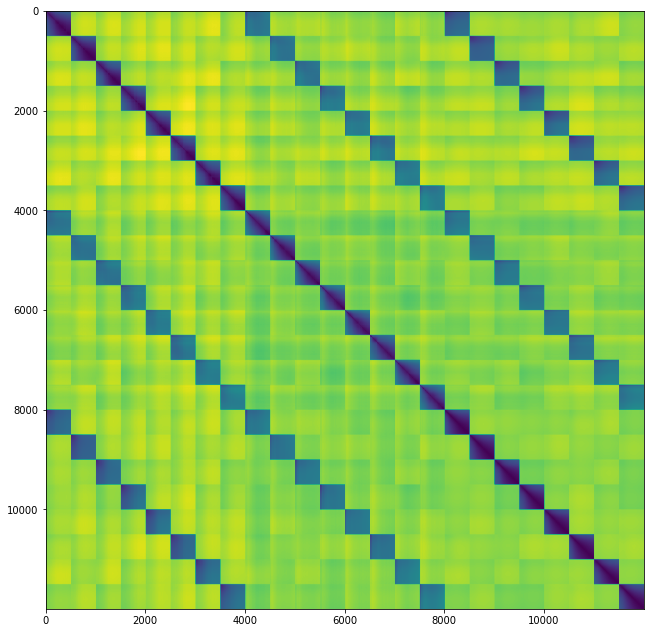

In [23]:
M = result['rec_weight_distances']
M = M + M.T
plt.figure(figsize=(11, 11))
plt.imshow(M)

In [7]:
checkpoints['checkpoint_0'].keys()

dict_keys(['rnn', 'i_t', 'participation_coef', 'fixed_points', 'KE', 'KE_criterion', 'cluster_means', 'cluster_labels', 'V', 'A_init', 'cluster_eigs', 'cluster_KEs', 'test_loss', 'adjacency_matrix', 'nodes', 'adjmat_input_0', 'adjmat_input_1', 'adjmat_input_2', 'adjmat_input_3', 'adjmat_input_4', 'adjmat_input_5'])

In [ ]:
result['analysis_job_names']

In [4]:
root_name = 'three_algs'
results_dir = '/scratch/oem214/learning-dynamics/results/PNAS_Paper'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                   'checkpoints': checkpoints}

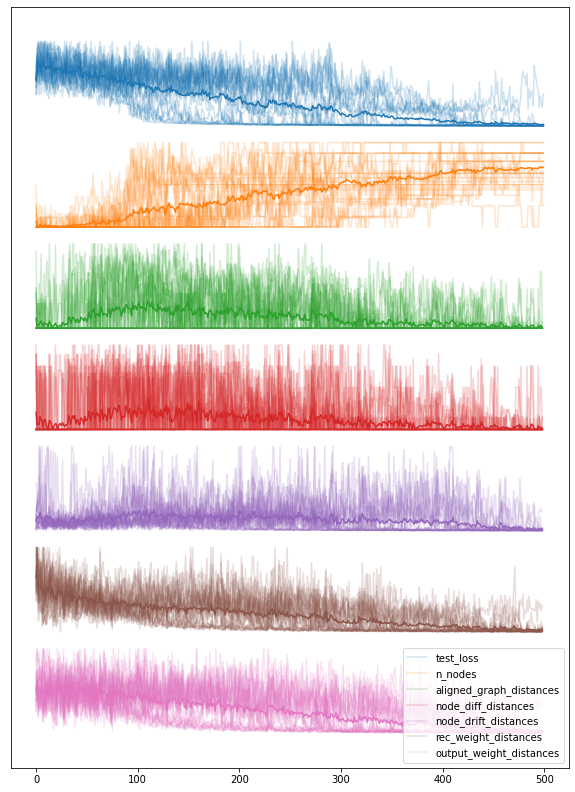

In [5]:
signal_keys = [k for k in signal_dicts.keys()]
signal_dicts_list = [signal_dicts[k] for k in signal_keys]
fig = plot_multiple_signals(signal_dicts_list, key_restriction=None, alpha=0.2)

In [64]:
#x = [s[::-1] for s in sorted([s[::-1] for s in signal_keys])]
#signal_keys_ordered = x[(len(x) // 2):] + x[:(len(x) // 2)]
signal_keys_ordered = signal_keys
dict_of_stage_assignments = {}
dict_of_t_stage_transitions = {}
for signal_key in signal_keys_ordered:
    signals = signal_dicts[signal_key]
    stage_assignments, t_stage_transitions = assign_time_points_to_stages(signals,
                                                                          performance_criterion=0.05,
                                                                          topological_criterion=0.1,
                                                                          loss_window=20,
                                                                          topological_window=1)
    dict_of_stage_assignments[signal_key] = stage_assignments
    dict_of_t_stage_transitions[signal_key] = t_stage_transitions

In [65]:
dict_of_t_stage_transitions

{'analyze_three_algs_seed=0_learn_alg=BPTT': [48, 228, 233],
 'analyze_three_algs_seed=1_learn_alg=BPTT': [81, 221, 253],
 'analyze_three_algs_seed=2_learn_alg=BPTT': [81, 257, 322],
 'analyze_three_algs_seed=3_learn_alg=BPTT': [101, 226, 363],
 'analyze_three_algs_seed=4_learn_alg=BPTT': [77, 266, 296],
 'analyze_three_algs_seed=5_learn_alg=BPTT': [85, None, 323],
 'analyze_three_algs_seed=6_learn_alg=BPTT': [94, 266, 284],
 'analyze_three_algs_seed=7_learn_alg=BPTT': [81, 285, 310],
 'analyze_three_algs_seed=0_learn_alg=DNI': [238, 405, 416],
 'analyze_three_algs_seed=1_learn_alg=DNI': [101, 414, 439],
 'analyze_three_algs_seed=2_learn_alg=DNI': [18, 431, 445],
 'analyze_three_algs_seed=3_learn_alg=DNI': [30, 423, 481],
 'analyze_three_algs_seed=4_learn_alg=DNI': [14, None, 478],
 'analyze_three_algs_seed=5_learn_alg=DNI': [9, None, None],
 'analyze_three_algs_seed=6_learn_alg=DNI': [172, 398, 413],
 'analyze_three_algs_seed=7_learn_alg=DNI': [37, 454, 445],
 'analyze_three_algs_seed

In [8]:
signal_keys_ordered

['analyze_three_algs_seed=0_learn_alg=BPTT',
 'analyze_three_algs_seed=1_learn_alg=BPTT',
 'analyze_three_algs_seed=2_learn_alg=BPTT',
 'analyze_three_algs_seed=3_learn_alg=BPTT',
 'analyze_three_algs_seed=4_learn_alg=BPTT',
 'analyze_three_algs_seed=5_learn_alg=BPTT',
 'analyze_three_algs_seed=6_learn_alg=BPTT',
 'analyze_three_algs_seed=7_learn_alg=BPTT',
 'analyze_three_algs_seed=0_learn_alg=DNI',
 'analyze_three_algs_seed=1_learn_alg=DNI',
 'analyze_three_algs_seed=2_learn_alg=DNI',
 'analyze_three_algs_seed=3_learn_alg=DNI',
 'analyze_three_algs_seed=4_learn_alg=DNI',
 'analyze_three_algs_seed=5_learn_alg=DNI',
 'analyze_three_algs_seed=6_learn_alg=DNI',
 'analyze_three_algs_seed=7_learn_alg=DNI',
 'analyze_three_algs_seed=0_learn_alg=RFLO',
 'analyze_three_algs_seed=1_learn_alg=RFLO',
 'analyze_three_algs_seed=2_learn_alg=RFLO',
 'analyze_three_algs_seed=3_learn_alg=RFLO',
 'analyze_three_algs_seed=4_learn_alg=RFLO',
 'analyze_three_algs_seed=5_learn_alg=RFLO',
 'analyze_three_al

(-2495.0, 52395.0, -2.57, 1.17)

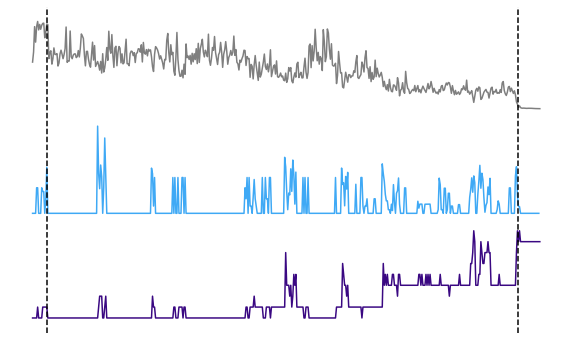

In [66]:
i_analysis = 12
key = signal_keys_ordered[i_analysis]
indices = checkpoints_dicts[key]['indices']
fig = plot_signals(signal_dicts[key], x_values=indices, signal_clips={}, legend=False,
                   colors=['#7F7F7F', '#3FA9F5', '#3A0882'],
                   key_restriction=['test_loss', 'aligned_graph_distances', 'n_nodes'],#, 'rec_weight_distances', 'n_nodes'],
                   stage_assignments=None)#dict_of_stage_assignments[key])
for t in dict_of_t_stage_transitions[key]:
    if t is not None:
        pass
        plt.axvline(indices[t], color='k', linestyle='--')
#plt.title(key)
#fig.savefig('../../figs/frf_talk/rflo_ex_loss.pdf', dpi=300, format='pdf')
plt.axis('off')

<ipython-input-67-fd267990c0c1>:21: RuntimeWarning: Mean of empty slice
  bar_plots[i_key, :] = np.array([np.nanmean(d_loss[np.where(sa == i_stage)[0]]) for i_stage in range(1, 5)])


(0.4099999999999999,
 4.590000000000001,
 -0.003483581996908148,
 0.00411232256167866)

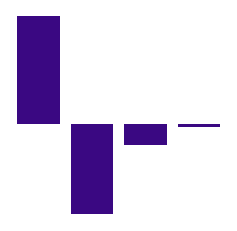

In [67]:
bar_plots = np.zeros((len(signal_keys_ordered), 4))
top_R_values = []
for i_key, key in enumerate(signal_keys_ordered):
    sa = dict_of_stage_assignments[key]
    signals = signal_dicts[key]
    k_filt = 1
    #loss = np.convolve(signals['test_loss'], np.ones(k_filt) / k_filt, 'valid')
    loss = uniform_filter1d(signals['test_loss'], k_filt, mode='nearest')
    #d_loss = loss
    d_loss = loss[1:] - loss[:-1]
    #d_top = np.convolve(signals['aligned_graph_distances'], np.ones(k_filt) / k_filt, 'valid')
    d_top = uniform_filter1d(signals['aligned_graph_distances'], k_filt, mode='nearest')
    #i_stage = 2
    #idx = np.where(stage_assignments > 0)[0]
    #plt.plot(d_top[idx], d_loss[idx], '.')
    from sklearn.linear_model import LinearRegression
    m = LinearRegression()
    #m.fit(d_top.reshape(-1, 1), d_loss.reshape(-1, 1))
    #print(m.score(d_top.reshape(-1, 1), d_loss.reshape(-1, 1)))
    #top_R_values.append(np.sqrt(m.score(d_top.reshape(-1, 1), d_loss.reshape(-1, 1))) * np.sign(m.coef_[0,0]))
    bar_plots[i_key, :] = np.array([np.nanmean(d_loss[np.where(sa == i_stage)[0]]) for i_stage in range(1, 5)])
    #plt.plot([1,2,3,4], [d_loss[np.where(sa == i_stage)[0]].mean() for i_stage in range(1, 5)])
fig = plt.figure(figsize=(4,4))    
plt.bar([1,2,3,4], np.nanmean(bar_plots, 0), color='#3A0882')
plt.axis('off')
#fig.savefig('../../figs/frf_talk/avg_dw_bar.pdf', dpi=300, format='pdf')

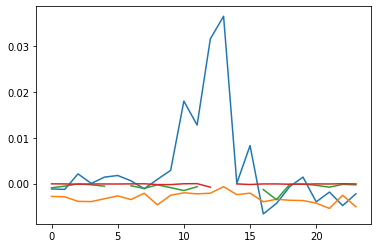

In [43]:
plt.plot(bar_plots)

In [ ]:
i_analysis = 14
key = signal_keys_ordered[i_analysis]
indices = checkpoints_dicts[key]['indices']
fig = plot_signals(signal_dicts[key], x_values=indices, signal_clips={}, legend=True,
                   key_restriction=['aligned_graph_distances', 'test_loss', 'rec_weight_distances', 'n_nodes'],
                   stage_assignments=dict_of_stage_assignments[key])
for t in dict_of_t_stage_transitions[key]:
    if t is not None:
        plt.axvline(indices[t], color='k', linestyle='--')
plt.title(key)

In [ ]:
i_analysis = 18
key = signal_keys_ordered[i_analysis]
indices = checkpoints_dicts[key]['indices']
fig = plot_signals(signal_dicts[key], x_values=indices, signal_clips={}, legend=True,
                   key_restriction=['aligned_graph_distances', 'test_loss', 'rec_weight_distances', 'n_nodes'],
                   stage_assignments=dict_of_stage_assignments[key])
for t in dict_of_t_stage_transitions[key]:
    if t is not None:
        plt.axvline(indices[t], color='k', linestyle='--')
plt.title(key)

In [ ]:
checkpoints_dicts.keys()

In [ ]:
dict_of_stage_assignments

In [ ]:
#colors = ['C0', 'C1', 'C2'] * 6
colors = []
for aj in analysis_jobs:
    if aj.split('=')[-1] == 'BPTT':
        colors.append('C5')
    if aj.split('=')[-1] == 'DNI':
        colors.append('C3')
plot_time_spent_in_stages(dict_of_stage_assignments, colors=colors)

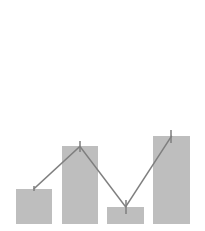

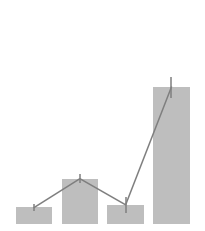

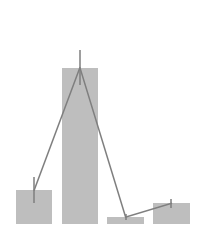

In [41]:
#saBPTT = [sa for i_sa, sa in enumerate(dict_of_stage_assignments) if 'BPTT' in signal_keys[i_sa]]
saBPTT = {k:v for k,v in zip(dict_of_stage_assignments.keys(),
                             dict_of_stage_assignments.values()) if 'BPTT' in k}
saRFLO = {k:v for k,v in zip(dict_of_stage_assignments.keys(),
                             dict_of_stage_assignments.values()) if 'RFLO' in k}
saDNI = {k:v for k,v in zip(dict_of_stage_assignments.keys(),
                             dict_of_stage_assignments.values()) if 'DNI' in k}
#saRFLO = [sa for i_sa, sa in enumerate(dict_of_stage_assignments) if 'RFLO' in signal_keys[i_sa]]
#saDNI = [sa for i_sa, sa in enumerate(dict_of_stage_assignments) if 'DNI' in signal_keys[i_sa]]

fig = plot_bar_time_spent_in_stages(saBPTT, color='#7F7F7F', return_fig=True)
plt.ylim([0, 500])
plt.yticks([])
plt.axis('off')
fig.savefig('../../figs/frf_talk/bptt_stage_occ.pdf', dpi=300, format='pdf')
fig = plot_bar_time_spent_in_stages(saRFLO, color='#7F7F7F', return_fig=True)
plt.ylim([0, 500])
plt.yticks([])
plt.axis('off')
fig.savefig('../../figs/frf_talk/rflo_stage_occ.pdf', dpi=300, format='pdf')
fig = plot_bar_time_spent_in_stages(saDNI, color='#7F7F7F', return_fig=True)
plt.ylim([0, 500])
plt.yticks([])
plt.axis('off')
fig.savefig('../../figs/frf_talk/dni_stage_occ.pdf', dpi=300, format='pdf')

In [ ]:
param_values = {'learn_alg': ['BPTT', 'DNI'], 'seed': list(range(5))}
key_order = ['learn_alg']
fig = plot_array_of_signals(signal_dicts, root_name=root_name, signal_keys=['test_loss'], alpha=0.4,
                            return_fig=True, fig_length=4, swap_order=False, param_values_=param_values,
                            key_order_=key_order)

In [ ]:
get_param_values_from_list_of_config_strings(analysis_jobs, 'algorithm_dense_variations')

In [ ]:
n_nodes_vec = np.array([])
for key in signal_keys_ordered:
    n_nodes_vec = np.concatenate([n_nodes_vec, signal_dicts[key]['n_nodes']])

In [ ]:
signal_keys_ordered

In [ ]:
algs = ['BPTT', 'DNI', 'RFLO']
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('owen', [('1'), '#3FA9F5'])
#n_nodes_vec = np.array([])
#for key in signal_keys_ordered:
#    n_nodes_vec = np.concatenate([n_nodes_vec, signal_dicts[key]['n_nodes']])
#total_nodes = np.add.outer(n_nodes_vec, n_nodes_vec)

fig = plt.figure()
M = result['aligned_graph_distances']
#M = (M + M.T) / total_nodes
M = M + M.T
plt.imshow(M, cmap=cmap)

for i_sim, i in enumerate(range(0, 12000, 500)):
    plt.axhline(y=i, color='k', linewidth=0.5)
    plt.axvline(x=i, color='k', linewidth=0.5)
#    key = signal_keys_ordered[i_sim]
#    for t in dict_of_t_stage_transitions[key]:
#        if t is not None and False:
#            plt.axhline(y=i+t, color='g')
#            plt.axvline(x=i+t, color='g')
plt.axhline(y=M.shape[0]*2/3, color='C3', linewidth=0.5)
plt.axvline(x=M.shape[0]*2/3, color='C3', linewidth=0.5)
plt.axhline(y=M.shape[0]/3, color='C3', linewidth=0.8)
plt.axvline(x=M.shape[0]/3, color='C3', linewidth=0.8)
plt.xticks([2000, 6000, 10000], algs)
plt.yticks([2000, 6000, 10000], algs)

figs_path = '../../figs/frf_talk/'
fig_name = 'all_sims'
#fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')



In [ ]:
plt.imshow(M[:500, :500], cmap=cmap)

In [ ]:
fig.savefig('../figs/bptt_dni_rflo_agd.pdf', format='pdf')

In [ ]:
### --- Cross stage analysis --- ###
base_string = 'analyze_three_algs_seed={}_learn_alg={}'
M = geo_result['PC2_distances']
M = M + M.T
algs = ['BPTT', 'DNI', 'RFLO']
cpj = 500 #checkpoints per job
n_jobs = 24
n_seeds = 8
n_stages = 4
stage_avg_array = np.zeros((n_jobs, n_jobs, n_stages, n_stages))
stage_std_array = np.zeros((n_jobs, n_jobs, n_stages, n_stages))
for i_seed in range(n_seeds):
    for i_alg, alg_1 in enumerate(algs):
        i = i_alg * n_seeds + i_seed
        for j_seed in range(n_seeds):
            for j_alg, alg_2 in enumerate(algs):
                j = j_alg * n_seeds + j_seed
                
                i_job_key = base_string.format(i_seed, alg_1)
                j_job_key = base_string.format(j_seed, alg_2)                
                i_sa = dict_of_stage_assignments[i_job_key]
                j_sa = dict_of_stage_assignments[j_job_key]
                
                submatrix = M[i * cpj:(i+1) * cpj,
                              j * cpj:(j+1) * cpj]
             
                for i_stage_idx, i_stage in enumerate([0, 1, 2, 3]):
                    for j_stage_idx, j_stage in enumerate([0, 1, 2, 3]):
                        
                        i_idx = np.where(i_sa == i_stage + 1)[0]
                        j_idx = np.where(j_sa == j_stage + 1)[0]
                        
                        stage_matrix = submatrix[i_idx, :][:, j_idx]
                        if stage_matrix.size > 0:
                            mean = stage_matrix.mean()
                            std = stage_matrix.std()
                        else:
                            mean = np.nan
                            std = np.nan
                        stage_avg_array[i, j, i_stage_idx, j_stage_idx] = mean
                        stage_std_array[i, j, i_stage_idx, j_stage_idx] = std

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('owen', [('1'), '#3FA9F5'])
geo_cmap = LinearSegmentedColormap.from_list('geo', [('1'), '#1A8E48'])

In [ ]:
for i, i_alg in enumerate(['bptt', 'dni', 'rflo']):
    for j, j_alg in enumerate(['bptt', 'dni', 'rflo']):
        fig = plt.figure()
        color = '#3FA9F5'
        plt.imshow(np.nanmean(np.nanmean(stage_avg_array[i*8:(i+1)*8,j*8:(j+1)*8], 0), 0), cmap=geo_cmap, vmin=0, vmax=1)
        plt.axis('off')
        plt.colorbar()
        figs_path = '../../figs/frf_talk/'
        fig_name = '{}_{}_comp'.format(i_alg, j_alg)
        #fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

In [ ]:
colors = (['C0'] * 8) + (['C1'] * 8) + (['C2'] * 8)
plot_3d_MDS_from_distance_matrix(M, result['job_indices'], colors=colors)

In [ ]:
b

In [6]:
root_name = 'frf_rein_grid'
rein_signal_dicts, rein_result = unpack_cross_compare_result(root_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                                                'n_nodes': get_checkpoint_n_stable_FPs},
                                                   results_subdir='PNAS_Paper',
                                                   multi_job_comp=False)

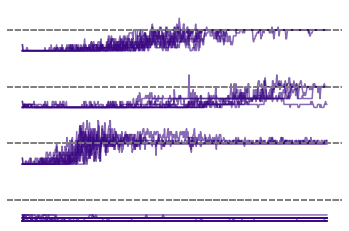

In [12]:
fig, ax = plt.subplots(4, 1)
color = '#3A0882'
for i_alg, alg in enumerate(['BPTT', 'DNI', 'RFLO']):
    for i_seed in range(8):
        key = 'analyze_three_algs_seed={}_learn_alg={}'.format(i_seed, alg)
        ax[i_alg].plot(signal_dicts[key]['n_nodes'], color=color, alpha=0.6)
        ax[i_alg].set_ylim([0,16])
        ax[i_alg].axis('off')
        ax[i_alg].axhline(y=8,color=('0.5'), linestyle='--')

keys = [k for k in rein_signal_dicts.keys()]
for key in keys:
    ax[3].plot(rein_signal_dicts[key]['n_nodes'], color=color, alpha=0.6)
    ax[3].set_ylim([0,16])
    ax[3].axis('off')
    ax[3].axhline(y=8,color=('0.5'), linestyle='--')
    
figs_path = '../../figs/frf_talk/'
fig_name = 'n_nodes_plot'
fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

In [7]:
rein_signal_dicts.keys()

dict_keys(['analyze_frf_rein_grid_seed=0_sigma=0,001_lr=0,001', 'analyze_frf_rein_grid_seed=1_sigma=0,001_lr=0,001', 'analyze_frf_rein_grid_seed=2_sigma=0,001_lr=0,001', 'analyze_frf_rein_grid_seed=3_sigma=0,001_lr=0,001', 'analyze_frf_rein_grid_seed=0_sigma=0,001_lr=0,01', 'analyze_frf_rein_grid_seed=1_sigma=0,001_lr=0,01', 'analyze_frf_rein_grid_seed=2_sigma=0,001_lr=0,01', 'analyze_frf_rein_grid_seed=3_sigma=0,001_lr=0,01', 'analyze_frf_rein_grid_seed=0_sigma=0,003_lr=0,001', 'analyze_frf_rein_grid_seed=1_sigma=0,003_lr=0,001', 'analyze_frf_rein_grid_seed=2_sigma=0,003_lr=0,001', 'analyze_frf_rein_grid_seed=3_sigma=0,003_lr=0,001', 'analyze_frf_rein_grid_seed=0_sigma=0,003_lr=0,01', 'analyze_frf_rein_grid_seed=1_sigma=0,003_lr=0,01', 'analyze_frf_rein_grid_seed=2_sigma=0,003_lr=0,01', 'analyze_frf_rein_grid_seed=3_sigma=0,003_lr=0,01', 'analyze_frf_rein_grid_seed=0_sigma=0,01_lr=0,001', 'analyze_frf_rein_grid_seed=1_sigma=0,01_lr=0,001', 'analyze_frf_rein_grid_seed=2_sigma=0,01_lr=0

In [ ]:
dict_of_t_stage_transitions['analyze_three_algs_seed=0_learn_alg=BPTT']
#dict_of_stage_assignments['analyze_three_algs_seed=0_learn_alg=BPTT']

In [ ]:
plt.imshow(np.nanmean(np.nanmean(stage_avg_array[:8, :8], 0), 0), cmap='Greys')
#plt.xticks([0, 1, 2], [1, 2, 4])
#plt.yticks([0, 1, 2], [1, 2, 4])
plt.colorbar()

In [ ]:
plt.imshow(np.nanmean(np.nanmean(stage_avg_array[8:16, 8:16], 0), 0), cmap='Greys')
#plt.xticks([0, 1, 2], [1, 2, 4])
#plt.yticks([0, 1, 2], [1, 2, 4])
plt.colorbar()

In [ ]:
plt.imshow(np.nanmean(np.nanmean(stage_avg_array[:8, 16:24], 0), 0), cmap='Greys')
#plt.xticks([0, 1, 2], [1, 2, 4])
#plt.yticks([0, 1, 2], [1, 2, 4])
plt.colorbar()

In [ ]:
import matplotlib
algs = ['DNI', 'RFLO']
n_networks = 10
n_stages = 4
n_rows = n_networks * n_stages
stages = [0, 1, 2, 3]
block_matrix = np.zeros((n_rows, n_rows))
plt.figure(figsize=(11, 11))
for i in range(0, n_rows, n_stages):
    for j in range(0, n_rows, n_stages):
        block_matrix[i:i+3,j:j+3] = stage_avg_array[i//4,j//4][stages][:, stages]
        plt.axhline(y=i-0.5, color='b', linewidth=0.08)
        plt.axvline(x=j-0.5, color='b', linewidth=0.08)
plt.axhline(y=40, color='r', linewidth=0.2)
plt.axvline(x=40, color='r', linewidth=0.2)

masked_array = np.ma.array (block_matrix, mask=np.isnan(block_matrix))
cmap = matplotlib.cm.RdBu
cmap.set_bad(('0.5'),1.)
plt.imshow(masked_array, interpolation='nearest', cmap=cmap)
plt.xticks([7, 22], algs)
plt.yticks([7, 22], algs)
plt.axhline(y=block_matrix.shape[0]/2 - 0.5, color='g')
plt.axvline(x=block_matrix.shape[0]/2 - 0.5, color='g')
#plt.imshow(block_matrix, cmap='Greys')

In [ ]:
plt.imshow(np.nanmean(np.nanmean(stage_avg_array[10:, :10], 0), 0))
plt.colorbar()

In [ ]:
plt.imshow(np.nanmean(np.nanmean(stage_avg_array[10:, 10:], 0), 0))
plt.colorbar()

In [ ]:
param_values_ = {'learn_alg': ['BPTT', 'DNI', 'RFLO'], 'seed': list(range(8))}
fig = plot_array_of_signals(signal_dicts, root_name=root_name, signal_keys=['aligned_graph_distances'], alpha=0.4,
                            return_fig=True, fig_length=4, swap_order=False,
                            param_values_=param_values_, key_order_=['learn_alg', 'seed'])

In [ ]:
figs_path = '../../figs/frf_talk/'
fig_name = 'dni_vs_bptt_normalized_node_diff_corr'
fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')